In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


plt.rcParams["figure.figsize"] = (20, 10)
random.seed(1)

In [2]:
def gradient_descent(gradient_func, start_point, iterations, eps):
    '''
    Метод градиентного спуска
    :param gradient_func: функция градиента
    :param step_func: функция изменения шага
    :param start_point: начальное приближение
    :param iterations: число итераций до остановки
    :param eps: максимальное расстояние между точками для остановки
    '''
    current_point = start_point
    for it in range(iterations):
        next_gradient = gradient_func.next_gradient(current_point)
        next_point = current_point - next_gradient

        distance = np.linalg.norm(current_point - next_point)
        if distance < eps:
            return current_point, it

        current_point = next_point

    return current_point, iterations

In [3]:
class MeanSquaredError:
    def function(self, regression, points, state):
        sum_square_error = 0.0
        for p in points:
            sum_square_error += (p[1] - regression.function(state, p[0])) ** 2
        return sum_square_error / len(points)

    def gradient(self, regression, points, state):
        sum_square_error = np.array([0.0] * len(state + 1))
        for p in points:
            sum_square_error -= 2 * (p[1] - regression.function(state, p[0])) * regression.gradient(state, p[0])
        return sum_square_error / len(points)

In [4]:
class StandartGradient:
    def __init__(self, regression, points, n, error_func, step):
        self.regression = regression
        self.points = points
        self.n = n
        self.error_func = error_func
        self.step = step

    def next_gradient(self, current_point):
        result = self.step * self.error_func.gradient(self.regression, random.sample(self.points, self.n), current_point)
        return result


class MomentumGradient:
    def __init__(self, regression, points, n, error_func, mu, step):
        # mu = 0.9
        self.regression = regression
        self.points = points
        self.n = n
        self.error_func = error_func
        self.mu = mu
        self.step = step
        self.prev_gradient = np.array([0.0] * (len(points[0][0]) + 1))

    def next_gradient(self, current_point):
        result = self.mu * self.prev_gradient + self.step * self.error_func.gradient(self.regression, random.sample(self.points, self.n), current_point)
        self.prev_gradient = result
        return result


class NesterovGradient:
    def __init__(self, regression, points, n, error_func, mu, step):
        # mu = 0.9
        self.regression = regression
        self.points = points
        self.n = n
        self.error_func = error_func
        self.mu = mu
        self.step = step
        self.prev_gradient = np.array([0.0] * (len(points[0][0]) + 1))

    def next_gradient(self, current_point):
        result = self.mu * self.prev_gradient + self.step * self.error_func.gradient(self.regression, random.sample(self.points, self.n), current_point + self.mu * self.prev_gradient)
        self.prev_gradient = result
        return result


class AdagradGradient:
    def __init__(self, regression, points, n, error_func, step):
        self.regression = regression
        self.points = points
        self.n = n
        self.error_func = error_func
        self.step = step
        self.s = np.array([0.0] * (len(points[0][0]) + 1))

    def next_gradient(self, current_point):
        current_gradient = self.error_func.gradient(self.regression, random.sample(self.points, self.n), current_point)
        self.s = self.s + np.square(current_gradient)
        result = np.multiply(self.step / np.sqrt(self.s), current_gradient)
        return result


class RMSPropGradient:
    def __init__(self, regression, points, n, error_func, mu, step):
        # mu = 0.9
        self.regression = regression
        self.points = points
        self.n = n
        self.error_func = error_func
        self.mu = mu
        self.step = step
        self.s = np.array([0.0] * (len(points[0][0]) + 1))

    def next_gradient(self, current_point):
        current_gradient = self.error_func.gradient(self.regression, random.sample(self.points, self.n), current_point)
        self.s = self.mu * self.s + (1 - self.mu) * np.square(current_gradient)
        result = np.multiply(self.step / np.sqrt(self.s), current_gradient)
        return result


class AdamGradient:
    def __init__(self, regression, points, n, error_func, beta1, beta2, step):
        # beta1 = 0.9
        # beta2 = 0.999
        self.regression = regression
        self.points = points
        self.n = n
        self.error_func = error_func
        self.beta1 = beta1
        self.beta2 = beta2
        self.step = step
        self.g = np.array([0.0] * (len(points[0][0]) + 1))
        self.v = np.array([0.0] * (len(points[0][0]) + 1))
        self.it = 1

    def next_gradient(self, current_point):
        current_gradient = self.error_func.gradient(self.regression, random.sample(self.points, self.n), current_point)
        self.g = self.beta1 * self.g + (1 - self.beta1) * current_gradient
        self.v = self.beta2 * self.v + (1 - self.beta2) * np.square(current_gradient)
        self.it = self.it + 1
        g_temp = self.g / (1 - self.beta1 ** (self.it - 1))
        v_temp = self.v / (1 - self.beta2 ** (self.it - 1))
        result = self.step * g_temp / (np.sqrt(v_temp) + 1e-8)
        return result

In [5]:
class LinearRegression:
    def function(self, state, point):
        res = state[0]
        for i in range(len(point)):
            res += state[i + 1] * point[i]
        return res

    def gradient(self, state, point):
        return np.concatenate(([1.0], point))

In [6]:
def generate_points(f):
    shifts = [random.uniform(-10, 10) for i in range(number_of_dimensions)]
    multipliers = [random.uniform(0.1, 2) for i in range(number_of_dimensions)]

    result = []
    for i in range(number_of_points):
        point = []
        for j in range(number_of_dimensions):
            x = (random.uniform(-5, 5) + shifts[j]) * multipliers[j]
            point.append(x)
        result.append((point, f(point)))

    return result

def f(xs):
    result = 1
    for i in range(len(xs)):
        result += (2 + i) * xs[i]
    return result

number_of_points = 100
number_of_dimensions = 50
train_points = generate_points(f)

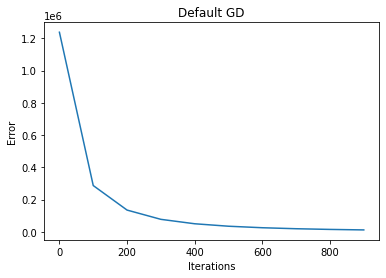

In [7]:
regression = LinearRegression()
error_func = MeanSquaredError()
step = 1e-4
eps = 1e-5

iterations = range(0, 1000, 100)
errors = []

for it in iterations:
    x = gradient_descent(
        gradient_func=StandartGradient(
            regression=regression,
            points=train_points,
            n=len(train_points),
            error_func=error_func,
            step=step
        ),
        start_point=np.array([0.0] * (len(train_points[0][0]) + 1)), 
        iterations=it,
        eps=eps
    )[0]
    errors.append(error_func.function(regression, train_points, x))

plt.title('Default GD')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.plot(iterations, errors)

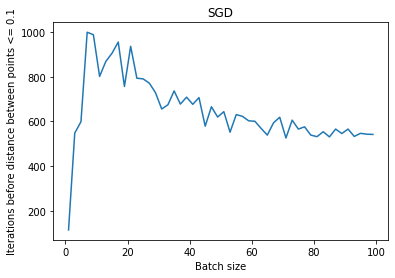

In [8]:
def draw_batch_size_to_iteration_plot(points, step, title):
    regression = LinearRegression()
    error_func = MeanSquaredError()
    eps = 1e-1

    batch_sizes = range(1, number_of_points + 1, 2)
    iterations = []

    for batch_size in batch_sizes:
        it = gradient_descent(
            gradient_func=StandartGradient(
                regression=regression,
                points=points,
                n=batch_size,
                error_func=error_func,
                step=step
            ),
            start_point=np.array([0.0] * (len(points[0][0]) + 1)), 
            iterations=1000,
            eps=eps
        )[1]
        iterations.append(it)

    plt.title(title)
    plt.xlabel('Batch size')
    plt.ylabel(f'Iterations before distance between points <= {eps}')
    plt.plot(batch_sizes, iterations)

draw_batch_size_to_iteration_plot(train_points, 1e-4, 'SGD')

In [9]:
shifts = []
multipliers = []

for i in range(number_of_dimensions):
    min = train_points[0][0][i]
    max = min
    for j in range(number_of_points):
        if min > train_points[j][0][i]:
            min = train_points[j][0][i]
        if max < train_points[j][0][i]:
            max = train_points[j][0][i]
    shifts.append((min + max) / 2)
    multipliers.append(2 / (max - min))

scaled_points = []
for p in train_points:
    scaled_points.append(([(p[0][i] - shifts[i]) * multipliers[i] for i in range(number_of_dimensions)], p[1]))

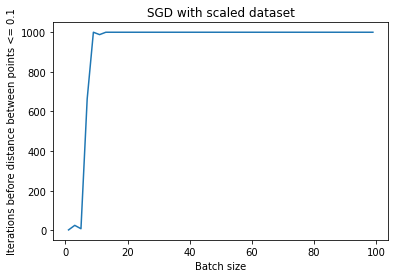

In [10]:
draw_batch_size_to_iteration_plot(scaled_points, 1e-4, 'SGD with scaled dataset')

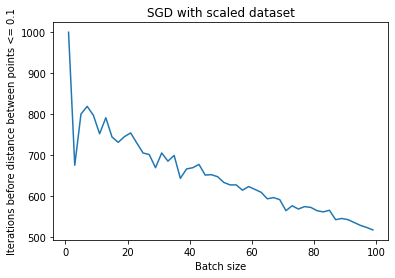

In [11]:
draw_batch_size_to_iteration_plot(scaled_points, 5e-2, 'SGD with scaled dataset')

In [12]:
def build_plot(label, get_gradient_func):
  regression = LinearRegression()
  error_func = MeanSquaredError()

  iterations = range(0, 1000, 10)
  errors = []

  for it in iterations:
      x = gradient_descent(
          gradient_func=get_gradient_func(regression, train_points, error_func),
          start_point=np.array([0.0] * (len(train_points[0][0]) + 1)), 
          iterations=it,
          eps=eps
      )[0]
      errors.append(error_func.function(regression, train_points, x))

  return plt.plot(iterations, errors, label=label)[0]

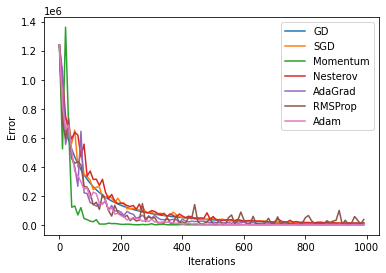

In [13]:
plots = [
    build_plot("GD", lambda regression, points, error_func:
              StandartGradient(
                  regression=regression,
                  points=points,
                  n=len(points),
                  error_func=error_func,
                  step=1e-4
              )),
    build_plot("SGD", lambda regression, points, error_func:
              StandartGradient(
                  regression=regression,
                  points=points,
                  n=int(len(points) / 20),
                  error_func=error_func,
                  step=1e-4
              )),
    build_plot("Momentum", lambda regression, points, error_func:
              MomentumGradient(
                      regression=regression,
                      points=points,
                      n=int(len(points) / 20),
                      error_func=error_func,
                      step=1e-4,
                      mu=0.9
              )),
    build_plot("Nesterov", lambda regression, points, error_func:
              NesterovGradient(
                  regression=regression,
                  points=points,
                  n=int(len(points) / 20),
                  error_func=error_func,
                  step=1e-5,
                  mu=0.9
              )),
    build_plot("AdaGrad", lambda regression, points, error_func:
                AdagradGradient(
                    regression=regression,
                    points=points,
                    n=int(len(points) / 20),
                    error_func=error_func,
                    step=1e1
                )),
    build_plot("RMSProp", lambda regression, points, error_func:
                RMSPropGradient(
                    regression=regression,
                    points=points,
                    n=int(len(points) / 20),
                    error_func=error_func,
                    mu=0.9,
                    step=1e-0
                )),
    build_plot("Adam", lambda regression, points, error_func:
                AdamGradient(
                    regression=regression,
                    points=points,
                    n=int(len(points) / 20),
                    error_func=error_func,
                    beta1=0.9,
                    beta2=0.999,
                    step=1e-0
                ))
]

plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend(handles=plots)

In [14]:
number_of_points = 100
number_of_dimensions = 1

def f(xs):
    return 10 - 4 * xs[0]

trajectory_train_points = generate_points(f)

In [17]:
fig = make_subplots(rows=7, cols=1, subplot_titles=("GD", "SGD", "Momentum", "Nesterov", "AdaGrad", "RMSProp", "Adam"))


xs = list(range(-2, 12))
ys = list(range(-8, 2))
zs = []
for y in ys:
    layer = []
    for x in xs:
        layer.append(error_func.function(regression, trajectory_train_points, [x, y]))
    zs.append(layer)

def draw_trajectory(title, row, get_gradient_func):
    regression = LinearRegression()
    error_func = MeanSquaredError()
    eps = 1e-5

    def calc_error(xs):
        return error_func.function(regression, trajectory_train_points, xs)

    iterations = range(0, 1000, 5)

    points = [
        gradient_descent(
            gradient_func=get_gradient_func(regression, trajectory_train_points, error_func),
            start_point=np.array([0.0] * (len(trajectory_train_points[0][0]) + 1)), 
            iterations=it,
            eps=eps
        )[0]
        for it in iterations
    ]

    fig.add_trace(go.Contour(x=xs, y=ys, z=zs), row=row, col=1)
    fig.add_trace(go.Scatter(x=[p[0] for p in points], y=[p[1] for p in points], mode='lines', line=dict(color='lightgreen')), row=row, col=1)

draw_trajectory('GD', 1, lambda regression, points, error_func:
    StandartGradient(
        regression=regression,
        points=points,
        n=len(points),
        error_func=error_func,
        step=1e-3
    ))

draw_trajectory('SGD', 2, lambda regression, points, error_func:
    StandartGradient(
        regression=regression,
        points=points,
        n=int(len(points) / 20),
        error_func=error_func,
        step=1e-3
    ))

draw_trajectory("Momentum", 3, lambda regression, points, error_func:
    MomentumGradient(
        regression=regression,
        points=points,
        n=int(len(points) / 20),
        error_func=error_func,
        step=1e-3,
        mu=0.9
    ))

draw_trajectory("Nesterov", 4, lambda regression, points, error_func:
    NesterovGradient(
        regression=regression,
        points=points,
        n=int(len(points) / 20),
        error_func=error_func,
        step=1e-3,
        mu=0.9
    ))

draw_trajectory("AdaGrad", 5, lambda regression, points, error_func:
    AdagradGradient(
        regression=regression,
        points=points,
        n=int(len(points) / 20),
        error_func=error_func,
        step=2
    ))

draw_trajectory("RMSProp", 6, lambda regression, points, error_func:
    RMSPropGradient(
        regression=regression,
        points=points,
        n=int(len(points) / 20),
        error_func=error_func,
        mu=0.9,
        step=2e-1
    ))

draw_trajectory("Adam", 7, lambda regression, points, error_func:
    AdamGradient(
        regression=regression,
        points=points,
        n=int(len(points) / 20),
        error_func=error_func,
        beta1=0.9,
        beta2=0.999,
        step=2e-1
    ))

fig.update_layout(height=3000, width=1400)
fig.show()